<a href="https://colab.research.google.com/github/aaronbui99/Breast-Cancer-Detection-CNN-FastAPI-AWS-Django/blob/main/notebook6490f9865c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
paultimothymooney_breast_histopathology_images_path = kagglehub.dataset_download('paultimothymooney/breast-histopathology-images')

print('Data source import complete.')


Data source import complete.


**Import libraries**

In [ ]:
!pip install opencv-python


In [ ]:
import os
import glob
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


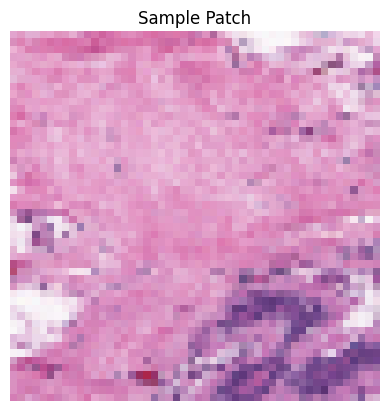

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Example path to a sample image (adjust based on your walk output)
sample_image_path = '/kaggle/input/breast-histopathology-images/10253/0/10253_idx5_x1001_y1001_class0.png'

img = cv2.imread(sample_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title("Sample Patch")
plt.axis('off')
plt.show()


In [ ]:
import glob
import random

# Get all image paths
all_image_paths = glob.glob('/kaggle/input/breast-histopathology-images/*/*/*.png')


# Assign label from filename (1 if _1_ is in name)
data = [(path, 1 if '1' in os.path.basename(path) else 0) for path in all_image_paths]

# Downsample to a balanced set (e.g., 2000 from each class)
class_0 = [d for d in data if d[1] == 0]
class_1 = [d for d in data if d[1] == 1]
print(f"Class 0 count: {len(class_0)}")
print(f"Class 1 count: {len(class_1)}")

Class 0 count: 0
Class 1 count: 277524


**Created A Balanced Dataset for testing**

In [ ]:
import glob
import random

# Get all image paths
all_image_paths = glob.glob('/kaggle/input/breast-histopathology-images/*/*/*.png')

# Assign label from filename (1 if _1_ is in name)
data = [(path, int(os.path.basename(os.path.dirname(path)))) for path in all_image_paths]

# Separate by class
class_0 = [d for d in data if d[1] == 0]
class_1 = [d for d in data if d[1] == 1]

print(f"Class 0 count: {len(class_0)}")
print(f"Class 1 count: {len(class_1)}")

min_samples = min(len(class_0), len(class_1), 10000)
sampled_data = random.sample(class_0, min_samples) + random.sample(class_1, min_samples)
random.shuffle(sampled_data)

# Split into train and val
train_data, val_data = train_test_split(sampled_data, test_size=0.2, stratify=[x[1] for x in sampled_data])

#print(f"sampled_data: {sampled_data}")

Class 0 count: 198738
Class 1 count: 78786


**Prepare for Training**

In [ ]:
X = []
y = []

for path, label in sampled_data:
    img = cv2.imread(path)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(X)
print(y)

[[[[0.64705882 0.52941176 0.82745098]
   [0.59607843 0.43921569 0.72941176]
   [0.61176471 0.45098039 0.75686275]
   ...
   [0.59607843 0.43921569 0.75686275]
   [0.56862745 0.39607843 0.70196078]
   [0.56470588 0.40784314 0.76078431]]

  [[0.6745098  0.54117647 0.81176471]
   [0.62352941 0.4745098  0.79215686]
   [0.61176471 0.46666667 0.81568627]
   ...
   [0.61960784 0.48235294 0.83137255]
   [0.61176471 0.4627451  0.81960784]
   [0.60784314 0.47058824 0.84313725]]

  [[0.70588235 0.57647059 0.8       ]
   [0.66666667 0.5254902  0.81176471]
   [0.63529412 0.49803922 0.83137255]
   ...
   [0.62745098 0.50196078 0.86666667]
   [0.61960784 0.49019608 0.86666667]
   [0.61176471 0.48235294 0.87058824]]

  ...

  [[0.69411765 0.58431373 0.78823529]
   [0.77254902 0.68627451 0.79607843]
   [0.70588235 0.58431373 0.68627451]
   ...
   [0.58039216 0.45098039 0.85490196]
   [0.58823529 0.45882353 0.85098039]
   [0.62745098 0.49019608 0.85098039]]

  [[0.65098039 0.50196078 0.74509804]
   [0.6

**Define Dataset Class**

In [ ]:
class HistopathologyDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)


print(f"Define success")

Define success


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_dataset = HistopathologyDataset(train_data, train_transform)
val_dataset = HistopathologyDataset(val_data, val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


print(f"Train dataset: {train_dataset}")
print(f"Val dataset: {val_dataset}")

print(f"Train loader: {train_loader}")
print(f"Val loader: {val_loader}")

Train dataset: <__main__.HistopathologyDataset object at 0x78c33cd3b390>
Val dataset: <__main__.HistopathologyDataset object at 0x78c33cd3b750>
Train loader: <torch.utils.data.dataloader.DataLoader object at 0x78c220377e50>
Val loader: <torch.utils.data.dataloader.DataLoader object at 0x78c269701290>


**Define a CNN Model**

In [ ]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 64x64 → 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 32x32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # → 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 16x16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # → 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # → 8x8
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)  # raw logit
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(-1)  # Ensure shape [batch_size]


**Train model**

In [ ]:
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import StepLR
import numpy as np

EPOCHS = 100
PATIENCE = 10  # Stop training if no improvement after this many epochs
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

# --- Choose optimizer ---
optimizer = torch.optim.AdamW(model.parameters(), lr=0.003)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# Loss function
criterion = torch.nn.BCEWithLogitsLoss()

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    scheduler.step()

    avg_loss = running_loss / total
    train_accuracy = correct / total
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # ---------------- Validation ----------------
    model.eval()
    val_loss = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float().cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation metrics for Epoch {epoch+1}:\n{classification_report(y_true, y_pred, digits=4)}")

    # ---------------- Early Stopping ----------------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            early_stop = True
            break

if early_stop:
    model.load_state_dict(torch.load("best_model.pth"))


Epoch 1, Loss: 0.6415, Train Accuracy: 0.7739
Validation Loss: 0.5255
Validation metrics for Epoch 1:
              precision    recall  f1-score   support

         0.0     0.8388    0.6140    0.7090      2000
         1.0     0.6956    0.8820    0.7778      2000

    accuracy                         0.7480      4000
   macro avg     0.7672    0.7480    0.7434      4000
weighted avg     0.7672    0.7480    0.7434      4000

Epoch 2, Loss: 0.5072, Train Accuracy: 0.7812
Validation Loss: 0.4432
Validation metrics for Epoch 2:
              precision    recall  f1-score   support

         0.0     0.8804    0.6700    0.7609      2000
         1.0     0.7337    0.9090    0.8120      2000

    accuracy                         0.7895      4000
   macro avg     0.8070    0.7895    0.7865      4000
weighted avg     0.8070    0.7895    0.7865      4000

Epoch 3, Loss: 0.4964, Train Accuracy: 0.7809
Validation Loss: 0.4935
Validation metrics for Epoch 3:
              precision    recall  f1-sc

In [ ]:
torch.save(model.state_dict(), "best_model.pth")


In [ ]:
from google.colab import files
files.download("best_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>